In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier # Load k-NN from sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import datetime as dt


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix

from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from mlens.ensemble import SuperLearner
from sklearn.ensemble import ExtraTreesClassifier


In [148]:
def get_auc(y, y_pred_probabilities, class_labels, column =1, plot = True):
    fpr, tpr, _ = roc_curve(y == column, y_pred_probabilities[:,column])
    roc_auc = roc_auc_score(y_true=y, y_score=y_pred_probabilities[:,1])
    print ("AUC: ", roc_auc)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# Loading datasets

In [149]:
main_df2 = pd.read_csv('all_diagnoses.csv')
vitals_df = pd.read_csv("vitals_df.csv")
severity_scores_df = pd.read_csv('severity_scores_df.csv')

In [150]:
main_df2.shape

(968526, 21)

In [151]:
vitals_df.shape

(26106, 27)

In [152]:
severity_scores_df=severity_scores_df.drop_duplicates(subset='subject_id',keep='first').sort_values(by='subject_id')

In [154]:
# Removing redundant columns Subject_ID and HADM_ID
severity_scores_df = severity_scores_df.drop(['subject_id','hadm_id','hospital_expire_flag','ICUSTAY_AGE_GROUP',
                                              'OASIS', 'OASIS_PROB','age_score','preiculos_score', 'gcs_score',
                                                'heartrate_score', 'meanbp_score',
                                               'resprate_score', 'temp_score',
                                               'UrineOutput_score', 'mechvent_score',
                                               'electivesurgery_score', 'SAPS', 'resp_score', 'vent_score',
                                               'hematocrit_score', 'glucose_score', 'SAPSII', 'SAPSII_PROB',
                                               'PaO2FiO2_score', 'bilirubin_score', 'comorbidity_score',
                                               'admissiontype_score', 'SOFA','INTIME','age'], axis=1) 
#icustay_expire_flag

# Pre-Processing

## Top 50 Diagnoses & Interactions

In [158]:
from itertools import combinations

def check_interactions(data,diagnoses):
    #a = ["Single lb in-hosp w/o cs","Crnry athrscl natve vssl"]
    count_all = []
    count_deaths_all = []
    combo1 = []
    combo2 = []
    icu_ids = []
    for i,j in combinations(diagnoses, 2):
        count = 0
        count_deaths = 0
        print(i,j)
        icu_i = data['ICUSTAY_ID'][data['SHORT_TITLE'] == i].unique()
        icu_j = data['ICUSTAY_ID'][data['SHORT_TITLE'] == j].unique()
        both = [value for value in icu_i if value in icu_j]
        
        for icu_stay in both:
            data_subset = data[data['ICUSTAY_ID'] == icu_stay]
            count += 1
            count_deaths += [i for i in data_subset['HOSPITAL_EXPIRE_FLAG']][0] #data_subset['HOSPITAL_EXPIRE_FLAG'].to_list()[0] 
        print(count_deaths)
        print(count)
        combo1.append(i)
        combo2.append(j)
        count_all.append(count)
        count_deaths_all.append(count_deaths)
        icu_ids.append(both)
    return combo1, combo2, count_all, count_deaths_all, icu_ids

In [159]:
deathrate = []
count_deaths_list = []

for condition in main_df2['SHORT_TITLE'].unique():
    subset = main_df2[main_df2['SHORT_TITLE']==condition]
    count = subset.shape[0]
    count_deaths = subset['HOSPITAL_EXPIRE_FLAG'].sum()
    deathrate.append(count_deaths/count)
    count_deaths_list.append(count_deaths)

In [160]:
deathrate_df = pd.DataFrame()
deathrate_df['SHORT_TITLE'] = main_df2['SHORT_TITLE'].unique()
deathrate_df['DEATHRATE'] = deathrate
deathrate_df['PATIENT_COUNT'] = count_deaths_list
deathrate_df_sorted = deathrate_df.sort_values(by='DEATHRATE',ascending=False)
deathrate_df_sorted_top=deathrate_df_sorted[deathrate_df_sorted["PATIENT_COUNT"]>=10]

In [161]:
dr_df = deathrate_df_sorted_top.copy()
dr_df.loc[(dr_df['DEATHRATE'] >= 0.7), 'DEATHRATE_CAT'] = 2
dr_df.loc[(dr_df['DEATHRATE'] < 0.7) & (dr_df['DEATHRATE'] >= 0.5), 'DEATHRATE_CAT'] = 1
dr_df.loc[(dr_df['DEATHRATE'] < 0.5), 'DEATHRATE_CAT'] = 0

In [162]:
top50_diagn = dr_df[dr_df["PATIENT_COUNT"]>=10].head(50)['SHORT_TITLE']
combo1, combo2, count_all, count_deaths_all, icu_ids = check_interactions(main_df2,top50_diagn)

Brain death Subdural hem-deep coma
0
0
Brain death Subarach hem-deep coma
0
0
Brain death Cl skl base fx-deep coma
1
1
Brain death Mult myeloma in relapse
0
0
Brain death Brain hem NEC-deep coma
0
0
Brain death Cl skul vlt fx-deep coma
0
0
Brain death Vascular disorder, penis
0
0
Brain death Encountr palliative care
1
1
Brain death Myelofi w myelo metaplas
0
0
Brain death Brain lac NEC-deep coma
0
0
Brain death Ac duoden ulc w hem/perf
0
0
Brain death Pneum in oth sys mycoses
0
0
Brain death Agenesis of lung
0
0
Brain death Brain inj NEC-deep coma
0
0
Brain death Coma
3
3
Brain death Nontrauma comp syn-abd
0
0
Brain death Chr lymp leuk in relapse
0
0
Brain death Gouty tophi site NEC
0
0
Brain death Defibrination syndrome
0
0
Brain death Kyphosis in oth dis
0
0
Brain death Ot art emb/thrm abd aort
0
0
Brain death Choledocholith/ac gb inf
0
0
Brain death Hemophagocytic syndromes
0
0
Brain death Ac graft-versus-host dis
0
0
Brain death Anoxic brain damage
2
2
Brain death Postop shock, oth

0
0
Cl skl base fx-deep coma React-periton dialy cath
0
0
Cl skl base fx-deep coma Extreme immatur <500g
0
0
Cl skl base fx-deep coma Mucosits d/t antineo rx
0
0
Cl skl base fx-deep coma Hpt C w hepatic coma NOS
0
0
Cl skl base fx-deep coma Noninflam dis vagina NEC
0
0
Cl skl base fx-deep coma Compl marrow transplant
0
0
Cl skl base fx-deep coma Mal neo lymph node-mult
0
0
Cl skl base fx-deep coma SIRS-noninf w ac org dys
0
0
Cl skl base fx-deep coma Bronchopneumonia org NOS
0
0
Cl skl base fx-deep coma Ac myl leuk wo achv rmsn
0
0
Cl skl base fx-deep coma Epil par cont w intr epi
0
0
Cl skl base fx-deep coma Shock NOS
0
0
Cl skl base fx-deep coma Do not resusctate status
6
6
Cl skl base fx-deep coma Acute necrosis of liver
0
0
Mult myeloma in relapse Brain hem NEC-deep coma
0
0
Mult myeloma in relapse Cl skul vlt fx-deep coma
0
0
Mult myeloma in relapse Vascular disorder, penis
0
0
Mult myeloma in relapse Encountr palliative care
0
0
Mult myeloma in relapse Myelofi w myelo metaplas
0


0
0
Vascular disorder, penis Ac graft-versus-host dis
0
0
Vascular disorder, penis Anoxic brain damage
0
0
Vascular disorder, penis Postop shock, other
0
0
Vascular disorder, penis Pulmonary mycobacteria
0
0
Vascular disorder, penis Graft-versus-host NOS
0
0
Vascular disorder, penis Asphyxiation/strangulat
0
0
Vascular disorder, penis Mycs fng unsp xtrndl org
0
0
Vascular disorder, penis Hpt C acute w hepat Coma
0
0
Vascular disorder, penis Cardiac arrest
0
0
Vascular disorder, penis Chr duoden ulc hem/perf
0
0
Vascular disorder, penis Hpt B acte coma wo dlta
0
0
Vascular disorder, penis Choleperitonitis
0
0
Vascular disorder, penis React-periton dialy cath
0
0
Vascular disorder, penis Extreme immatur <500g
0
0
Vascular disorder, penis Mucosits d/t antineo rx
0
0
Vascular disorder, penis Hpt C w hepatic coma NOS
0
0
Vascular disorder, penis Noninflam dis vagina NEC
0
0
Vascular disorder, penis Compl marrow transplant
0
0
Vascular disorder, penis Mal neo lymph node-mult
0
0
Vascular dis

0
0
Ac duoden ulc w hem/perf Graft-versus-host NOS
0
0
Ac duoden ulc w hem/perf Asphyxiation/strangulat
0
0
Ac duoden ulc w hem/perf Mycs fng unsp xtrndl org
0
0
Ac duoden ulc w hem/perf Hpt C acute w hepat Coma
0
0
Ac duoden ulc w hem/perf Cardiac arrest
1
1
Ac duoden ulc w hem/perf Chr duoden ulc hem/perf
0
0
Ac duoden ulc w hem/perf Hpt B acte coma wo dlta
0
0
Ac duoden ulc w hem/perf Choleperitonitis
2
2
Ac duoden ulc w hem/perf React-periton dialy cath
0
0
Ac duoden ulc w hem/perf Extreme immatur <500g
0
0
Ac duoden ulc w hem/perf Mucosits d/t antineo rx
0
0
Ac duoden ulc w hem/perf Hpt C w hepatic coma NOS
0
0
Ac duoden ulc w hem/perf Noninflam dis vagina NEC
0
0
Ac duoden ulc w hem/perf Compl marrow transplant
0
0
Ac duoden ulc w hem/perf Mal neo lymph node-mult
0
0
Ac duoden ulc w hem/perf SIRS-noninf w ac org dys
0
0
Ac duoden ulc w hem/perf Bronchopneumonia org NOS
0
0
Ac duoden ulc w hem/perf Ac myl leuk wo achv rmsn
0
0
Ac duoden ulc w hem/perf Epil par cont w intr epi
0
0


5
7
Nontrauma comp syn-abd Chr duoden ulc hem/perf
0
0
Nontrauma comp syn-abd Hpt B acte coma wo dlta
0
0
Nontrauma comp syn-abd Choleperitonitis
1
1
Nontrauma comp syn-abd React-periton dialy cath
0
0
Nontrauma comp syn-abd Extreme immatur <500g
0
0
Nontrauma comp syn-abd Mucosits d/t antineo rx
0
0
Nontrauma comp syn-abd Hpt C w hepatic coma NOS
0
0
Nontrauma comp syn-abd Noninflam dis vagina NEC
0
0
Nontrauma comp syn-abd Compl marrow transplant
0
0
Nontrauma comp syn-abd Mal neo lymph node-mult
0
0
Nontrauma comp syn-abd SIRS-noninf w ac org dys
1
5
Nontrauma comp syn-abd Bronchopneumonia org NOS
0
0
Nontrauma comp syn-abd Ac myl leuk wo achv rmsn
1
1
Nontrauma comp syn-abd Epil par cont w intr epi
0
0
Nontrauma comp syn-abd Shock NOS
3
3
Nontrauma comp syn-abd Do not resusctate status
6
7
Nontrauma comp syn-abd Acute necrosis of liver
13
23
Chr lymp leuk in relapse Gouty tophi site NEC
0
0
Chr lymp leuk in relapse Defibrination syndrome
0
0
Chr lymp leuk in relapse Kyphosis in oth

5
6
Ot art emb/thrm abd aort Acute necrosis of liver
2
2
Choledocholith/ac gb inf Hemophagocytic syndromes
0
0
Choledocholith/ac gb inf Ac graft-versus-host dis
0
0
Choledocholith/ac gb inf Anoxic brain damage
0
0
Choledocholith/ac gb inf Postop shock, other
0
0
Choledocholith/ac gb inf Pulmonary mycobacteria
0
0
Choledocholith/ac gb inf Graft-versus-host NOS
0
0
Choledocholith/ac gb inf Asphyxiation/strangulat
0
0
Choledocholith/ac gb inf Mycs fng unsp xtrndl org
0
0
Choledocholith/ac gb inf Hpt C acute w hepat Coma
0
0
Choledocholith/ac gb inf Cardiac arrest
0
0
Choledocholith/ac gb inf Chr duoden ulc hem/perf
0
0
Choledocholith/ac gb inf Hpt B acte coma wo dlta
0
0
Choledocholith/ac gb inf Choleperitonitis
0
0
Choledocholith/ac gb inf React-periton dialy cath
0
0
Choledocholith/ac gb inf Extreme immatur <500g
0
0
Choledocholith/ac gb inf Mucosits d/t antineo rx
0
0
Choledocholith/ac gb inf Hpt C w hepatic coma NOS
0
0
Choledocholith/ac gb inf Noninflam dis vagina NEC
0
0
Choledochol

3
4
Graft-versus-host NOS Epil par cont w intr epi
0
0
Graft-versus-host NOS Shock NOS
0
0
Graft-versus-host NOS Do not resusctate status
4
4
Graft-versus-host NOS Acute necrosis of liver
0
0
Asphyxiation/strangulat Mycs fng unsp xtrndl org
0
0
Asphyxiation/strangulat Hpt C acute w hepat Coma
0
0
Asphyxiation/strangulat Cardiac arrest
3
3
Asphyxiation/strangulat Chr duoden ulc hem/perf
0
0
Asphyxiation/strangulat Hpt B acte coma wo dlta
0
0
Asphyxiation/strangulat Choleperitonitis
0
0
Asphyxiation/strangulat React-periton dialy cath
0
0
Asphyxiation/strangulat Extreme immatur <500g
0
0
Asphyxiation/strangulat Mucosits d/t antineo rx
0
0
Asphyxiation/strangulat Hpt C w hepatic coma NOS
0
0
Asphyxiation/strangulat Noninflam dis vagina NEC
0
0
Asphyxiation/strangulat Compl marrow transplant
0
0
Asphyxiation/strangulat Mal neo lymph node-mult
0
0
Asphyxiation/strangulat SIRS-noninf w ac org dys
0
0
Asphyxiation/strangulat Bronchopneumonia org NOS
1
1
Asphyxiation/strangulat Ac myl leuk wo 

2
2
Hpt C w hepatic coma NOS Epil par cont w intr epi
0
0
Hpt C w hepatic coma NOS Shock NOS
3
7
Hpt C w hepatic coma NOS Do not resusctate status
2
3
Hpt C w hepatic coma NOS Acute necrosis of liver
9
16
Noninflam dis vagina NEC Compl marrow transplant
0
1
Noninflam dis vagina NEC Mal neo lymph node-mult
0
0
Noninflam dis vagina NEC SIRS-noninf w ac org dys
0
0
Noninflam dis vagina NEC Bronchopneumonia org NOS
0
0
Noninflam dis vagina NEC Ac myl leuk wo achv rmsn
0
0
Noninflam dis vagina NEC Epil par cont w intr epi
0
0
Noninflam dis vagina NEC Shock NOS
0
0
Noninflam dis vagina NEC Do not resusctate status
5
5
Noninflam dis vagina NEC Acute necrosis of liver
2
2
Compl marrow transplant Mal neo lymph node-mult
0
0
Compl marrow transplant SIRS-noninf w ac org dys
0
0
Compl marrow transplant Bronchopneumonia org NOS
0
0
Compl marrow transplant Ac myl leuk wo achv rmsn
25
47
Compl marrow transplant Epil par cont w intr epi
0
0
Compl marrow transplant Shock NOS
0
0
Compl marrow transplant

In [163]:
interactions_df = pd.DataFrame()
interactions_df['diagnosis1']=combo1
interactions_df['diagnosis2']=combo2
interactions_df['total_count']=count_all
interactions_df['death_count']=count_deaths_all
interactions_df['icu_ids'] = icu_ids
death_rate=[]
for i,j in zip(count_deaths_all,count_all):
    if j!=0:
        death_rate.append(i/j)
    else:
        death_rate.append(0)
interactions_df['death_rate']=death_rate 
interactions_df= interactions_df[interactions_df['total_count']>=10].sort_values(by='death_rate', ascending=False)

# Join first Diagnosis with individual diagnosis deathrates
df_comp = interactions_df.merge(dr_df, how='left', left_on='diagnosis1',right_on="SHORT_TITLE")
df_comp = df_comp.drop(['SHORT_TITLE','PATIENT_COUNT','DEATHRATE_CAT'], axis=1)
df_comp = df_comp.rename(columns={"DEATHRATE": "deathrate_diagn1"})

# Join first Diagnosis with individual diagnosis deathrates
df_comp = df_comp.merge(dr_df, how='left', left_on='diagnosis2',right_on="SHORT_TITLE")
df_comp = df_comp.drop(['SHORT_TITLE','PATIENT_COUNT','DEATHRATE_CAT'], axis=1)
df_comp = df_comp.rename(columns={"DEATHRATE": "deathrate_diagn2"})

data_subset1 = df_comp[(df_comp['death_rate']) > (0.25 + df_comp['deathrate_diagn1'] ) ]
data_subset2 = df_comp[(df_comp['death_rate']) > (0.25 + df_comp['deathrate_diagn2'] ) ]
data_subset3 = pd.concat([data_subset1,data_subset2]).drop_duplicates(subset=['diagnosis1','diagnosis2','death_rate'])
data_subset3 = data_subset3.sort_values(by='death_rate',ascending=False)

In [164]:
# Set threshold at 0.9
data_subset3.loc[data_subset3['death_rate'] >= 0.9, 'death_rate_int_cat'] = 2
data_subset3.loc[(data_subset3['death_rate'] < 0.9) & (data_subset3['death_rate'] >= 0.5), 'death_rate_int_cat'] = 1

In [165]:
data_subset4 = data_subset3[['icu_ids','death_rate_int_cat']]

In [166]:
data_subset5 = pd.DataFrame(data_subset4.icu_ids.tolist(), index=data_subset4.death_rate_int_cat).stack().reset_index(level=1, drop=True).reset_index(name='icu_ids')[['icu_ids','death_rate_int_cat']]

data_subset6 = pd.concat([data_subset5.icu_ids,pd.get_dummies(data_subset5['death_rate_int_cat'], prefix='DEATHRATE_INT_CAT_',drop_first=False)],axis=1)
data_subset7 = data_subset6.groupby('icu_ids').sum()

data_subset8 = data_subset7.where(data_subset7<=1, 1)

In [167]:
categories = pd.get_dummies(dr_df['DEATHRATE_CAT'], prefix='DEATHRATE_CAT_',drop_first=True)
conditions_encoding = pd.concat([dr_df['SHORT_TITLE'],categories], axis=1)

In [168]:
main_df3 = main_df2.merge(conditions_encoding, how='left', on='SHORT_TITLE')

In [169]:
collapse_categories = main_df3[['ICUSTAY_ID','DEATHRATE_CAT__1.0', 'DEATHRATE_CAT__2.0']].groupby('ICUSTAY_ID').sum() #, 'DEATHRATE_CAT__3.0',
       #'DEATHRATE_CAT__4.0'
main_df2=main_df2.drop_duplicates(subset='ICUSTAY_ID',keep='first').sort_values(by='ICUSTAY_ID')
main_df2 = main_df2.merge(collapse_categories, how='left', on='ICUSTAY_ID')

In [170]:
main_sub = main_df2[['ICUSTAY_ID']].merge(data_subset8.reset_index(), how='left', left_on='ICUSTAY_ID', right_on='icu_ids')
main_sub = main_sub.drop('icu_ids',axis=1).fillna(0)
main_df2 = main_df2.merge(main_sub, how='left', on='ICUSTAY_ID')


In [171]:
df = main_df2.merge(severity_scores_df, how='left', left_on = 'ICUSTAY_ID' ,right_on='icustay_id')
df = df.merge(vitals_df, how='inner', on='icustay_id')

## Binary & One-Hot Encoding

In [172]:
# Binary Encoding

from category_encoders.binary import BinaryEncoder

diagnosis_encoder = BinaryEncoder()
diagnosis_binary = diagnosis_encoder.fit_transform(df['ICD9_CODE'].astype(str))

In [177]:
# Create dummies for Gender
gender_df =pd.get_dummies(df ['GENDER'],prefix='gender_', drop_first=True)

# Create dummies for Age Group
age_group_df =pd.get_dummies(df ['ICUSTAY_AGE_GROUP'], prefix='age_group_', drop_first=True)

# Merge all encoded variables
df2 = pd.concat([df,gender_df,age_group_df], axis=1) #, diagnosis_binary

In [178]:
df3 = df2.drop(['icustay_id', 'HOSPITAL_EXPIRE_FLAG', #hospital_expire_flag
               'ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'INTIME', 'OUTTIME', 'DIFF',
               'LAST_WARDID', 'GENDER','DOB', 'ICD9_CODE', 'SHORT_TITLE',
               'LONG_TITLE', 'SEQ_NUM', 'DEATHTIME','ICUSTAY_AGE_GROUP',"ADMISSION_TYPE",'INSURANCE','CURR_CAREUNIT','LOS'], axis=1)

In [310]:
# Prepare variables for model
y=df3['icustay_expire_flag']
X=df3.drop(['icustay_expire_flag'],axis=1)

# Split data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [311]:
orig_index = X_train.index

## Iterative Imputer

In [312]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

imp_iter = IterativeImputer(random_state=0)
imp_iter.fit(X_train)
X_train = imp_iter.transform(X_train)

In [313]:
X_train = pd.DataFrame(X_train)
X_train.columns = df3.drop(['icustay_expire_flag'],axis=1).columns

In [314]:
X_train.index = orig_index

In [315]:
X_test = imp_iter.transform(X_test)
X_test = pd.DataFrame(X_test)
X_test.columns = df3.drop(['icustay_expire_flag'],axis=1).columns

In [316]:
#X_train.isnull().sum()

In [317]:
y_train.shape, X_train.shape

((13497,), (13497, 50))

In [318]:
# Class imbalance
np.mean(y_train)

0.07557234941098022

In [327]:
X_train_unbalanced, X_test_unbalanced, y_train_unbalanced, y_test_unbalanced = X_train, X_test, y_train, y_test

In [320]:
# Remove some entries of class 0
import random
index_0 = [i for i in y_train[y_train == 0].index]
index_1 = [i for i in y_train[y_train == 1].index]
samp = random.sample(index_0, len(index_1))
samp.extend(index_1)
X_train = X_train.loc[samp,]
y_train = y_train.loc[samp,]

## Scaling

In [321]:
# Choose columns to be scaled for X_train
#scale_columns = ['age','preiculos', 'gcs', 'heartrate', 'meanbp', 'resprate', 'temp',
 #      'urineoutput', 'respiration',
 #      'coagulation', 'liver', 'cardiovascular', 'cns', 'renal'] #,'DAYS_FROM_ADMISSION'

scale_columns = ['age','preiculos', 'gcs', 'heartrate', 'meanbp', 'resprate', 'temp',
       'urineoutput', 'respiration',
       'coagulation', 'liver', 'cardiovascular', 'cns', 'renal','mechvent',
       'electivesurgery', 'subject_id', 'hadm_id', 'HeartRate_Min',
       'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max',
       'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min',
       'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max',
       'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min',
       'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean'] #,'DAYS_FROM_ADMISSION'


scale_df = X_train[scale_columns]

# Seperate the non-scaled columns (dummies) X_train
temp = X_train.drop(scale_columns,axis=1)
temp = temp.reset_index(drop=True)

# Apply actual scaling to X_train
scaler = preprocessing.StandardScaler().fit(scale_df) 
scale_tr = scaler.transform(scale_df) 
scale_df = pd.DataFrame(scale_tr,columns=scale_columns)

# Add the non-scaled and scaled dataframes back together
X_train = pd.concat([scale_df,temp], axis=1) 

#Choose columns to be scaled for X_test
scale_df2 = X_test[scale_columns]

# Seperate the non-scaled columns (dummies) X_test
temp2 = X_test.drop(scale_columns,axis=1)
temp2 = temp2.reset_index(drop=True)

# Apply actual scaling to X_test
# scaler2 = preprocessing.StandardScaler().fit(scale_df2) 
scale_tr2= scaler.transform(scale_df2) 
scale_df2=pd.DataFrame(scale_tr2,columns=scale_columns)

# Add the non-scaled and scaled dataframes back together X_test
X_test = pd.concat([scale_df2,temp2], axis=1) 

# Models

## Lasso

In [191]:
#Applying Lasso
model_lasso = LassoCV(alphas=[1,0.1,0.01,0.0005]).fit(X_train, y_train) #variating through different alphas
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
#y_pred_lasso = model_lasso.predict(X_test)

/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.308153558382827, tolerance: 0.025500000000000002
  tol, rng, random, positive)
/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7983140778566167, tolerance: 0.034
  tol, rng, random, positive)


In [192]:
df_coefs= coef

In [193]:
df_coefs.sort_values(ascending=True)

age_group__>89           -3.033528e-01
electivesurgery          -2.396081e-01
gcs                      -1.296690e-01
cns                      -7.982755e-02
urineoutput              -2.813414e-02
TempC_Mean               -2.769037e-02
gender__M                -1.276395e-02
heartrate                -1.137798e-02
TempC_Min                -1.062901e-02
SpO2_Max                 -9.039607e-03
preiculos                -5.307301e-03
resprate                 -3.830941e-03
SpO2_Min                 -3.600909e-03
MeanBP_Min               -2.688927e-03
SysBP_Mean               -2.558731e-03
HeartRate_Min            -2.077914e-03
RespRate_Max             -8.951936e-04
DiasBP_Min               -8.827896e-04
DiasBP_Max               -8.181062e-04
MeanBP_Max               -3.275407e-04
subject_id               -1.080414e-06
hadm_id                  -3.285550e-07
age_group__40-64          0.000000e+00
Glucose_Max               1.327586e-04
Glucose_Mean              1.713392e-04
SysBP_Max                

In [194]:
# IMPORTANT!!!!
# But one-hot encoding also presents two problems that are more particular to tree-based models:
# The resulting sparsity virtually ensures that continuous variables are assigned higher feature importance.
# A single level of a categorical variable must meet a very high bar in order to be selected for splitting early in the tree building. This can degrade predictive performance.

feature_names = X_train.columns
forest = RandomForestClassifier(n_estimators=20)  #Setting n_estimator to prevent overfitting
forest_fitted = forest.fit(X_train, y_train) 
scores = cross_val_score(forest, X_train, y_train, cv=5)
y_pred_forest = forest.predict(X_test)
y_pred_prob = forest.predict_proba(X_test)

In [195]:
# Step 5: Assess expected accuracy
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Step 6: Assess variable importance
importances = forest_fitted.feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=feature_names)
important_features.sort_values(ascending=False)

Accuracy: 0.84 (+/- 0.01)


SpO2_Min                  1.000000
DEATHRATE_CAT__2.0        0.713526
mechvent                  0.688401
SysBP_Min                 0.666839
urineoutput               0.664983
DEATHRATE_CAT__1.0        0.660649
cardiovascular            0.651300
RespRate_Mean             0.397240
gcs                       0.394939
Glucose_Max               0.386057
Glucose_Mean              0.368648
renal                     0.355749
SpO2_Mean                 0.353583
liver                     0.350243
age                       0.342650
respiration               0.321159
preiculos                 0.315756
Glucose_Min               0.306842
TempC_Max                 0.301643
TempC_Mean                0.299138
RespRate_Max              0.296908
HeartRate_Max             0.291415
MeanBP_Min                0.290087
HeartRate_Min             0.262147
temp                      0.259297
DiasBP_Min                0.259297
heartrate                 0.257942
meanbp                    0.247830
HeartRate_Mean      

In [196]:
def reweight(pi,q1=0.5,r1=0.5):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

q1 = 0.1 # population
r1 = 0.5 # training set

# Reweight class prediction probability


pred_rew_prob = reweight(y_pred_prob[:,1], q1, r1) #[i for i in 
# y_pred_prob = np.append(y_pred_prob, np.atleast_2d(pred_rew_prob).T, axis=1)
# Classification
pred_rew = [1 if i>0.5 else 0 for i in pred_rew_prob]

pred_prob = y_pred_prob[:,1]

AUC:  0.913036897819818


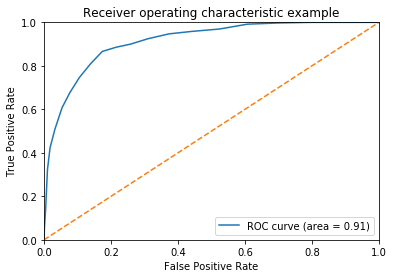

In [197]:
fpr, tpr, _ = roc_curve(y_test == 1, pred_rew_prob)
roc_auc = roc_auc_score(y_test, pred_rew_prob)
print ("AUC: ", roc_auc)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [198]:
print("Recall Score:")
print(recall_score(y_test,y_pred_forest))
print("Precision Score:")
print(precision_score(y_test,y_pred_forest))
print("Confusion matrix")
confusion_matrix(y_test,y_pred_forest)

Recall Score:
0.8662952646239555
Precision Score:
0.30164888457807953
Confusion matrix


array([[3421,  720],
       [  48,  311]])

In [199]:
from sklearn.metrics import auc, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test,pred_prob)
auc(recall, precision)

0.5528529291762042

In [200]:
print("Recall Score:")
print(recall_score(y_test,pred_rew))
print("Precision Score:")
print(precision_score(y_test,pred_rew))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew)

Recall Score:
0.3231197771587744
Precision Score:
0.7341772151898734
Confusion matrix


array([[4099,   42],
       [ 243,  116]])

In [201]:
from sklearn.metrics import auc, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test,pred_rew)
auc(recall, precision)

0.5556484961743239

In [202]:
thresh = np.arange(0,1,.05)
scores = []

for t in thresh:
    preds = [1 if i>t else 0 for i in pred_rew_prob]
    scores.append(f1_score(y_test, preds))

0.25


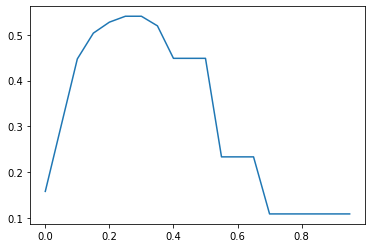

In [203]:
print(thresh[np.argmax(scores)])
plt.plot(thresh,scores)

In [204]:
pred_rew_best = [1 if i>thresh[np.argmax(scores)] else 0 for i in pred_rew_prob]
print("Recall Score:")
print(recall_score(y_test,pred_rew_best))
print("Precision Score:")
print(precision_score(y_test,pred_rew_best))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew_best)

Recall Score:
0.5097493036211699
Precision Score:
0.5754716981132075
Confusion matrix


array([[4006,  135],
       [ 176,  183]])

## Gradient Boosting

In [205]:
feature_names = X_train.columns
tree = GradientBoostingClassifier(n_estimators=50)  #Setting n_estimator to prevent overfitting
tree_fitted = tree.fit(X_train, y_train) 
scores = cross_val_score(tree, X_train, y_train, cv=5)
y_pred_tree = tree.predict(X_test)
y_pred_prob_tree = tree.predict_proba(X_test)
 
scores = cross_val_score(tree, X_train, y_train, cv=5)
y_pred_tree = tree.predict(X_test)
y_pred_prob_tree = tree.predict_proba(X_test)

In [206]:
# Step 5: Assess expected accuracy
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Step 6: Assess variable importance
importances = tree_fitted.feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=feature_names)
important_features.sort_values(ascending=False)

Accuracy: 0.85 (+/- 0.03)


mechvent                  1.000000
DEATHRATE_CAT__2.0        0.931755
DEATHRATE_CAT__1.0        0.925250
SpO2_Min                  0.852922
cardiovascular            0.618939
urineoutput               0.595211
gcs                       0.367746
electivesurgery           0.355400
RespRate_Mean             0.294773
SysBP_Min                 0.272129
age                       0.184821
renal                     0.182141
preiculos                 0.169358
liver                     0.167312
HeartRate_Max             0.133946
respiration               0.100314
Glucose_Max               0.080523
SysBP_Mean                0.070428
TempC_Mean                0.062795
Glucose_Mean              0.051647
MeanBP_Min                0.047477
HeartRate_Min             0.040398
meanbp                    0.038102
Glucose_Min               0.035361
heartrate                 0.028695
MeanBP_Mean               0.021480
TempC_Min                 0.021392
subject_id                0.021132
hadm_id             

In [207]:
def reweight(pi,q1=0.5,r1=0.5):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

q1 = 0.1 # population
r1 = 0.5 # training set

# Reweight class prediction probability


pred_rew_prob = reweight(y_pred_prob_tree[:,1], q1, r1) #[i for i in 
# y_pred_prob = np.append(y_pred_prob, np.atleast_2d(pred_rew_prob).T, axis=1)
# Classification
pred_rew = [1 if i>0.5 else 0 for i in pred_rew_prob]

pred_prob = y_pred_prob_tree[:,1]

AUC:  0.9268393583022954


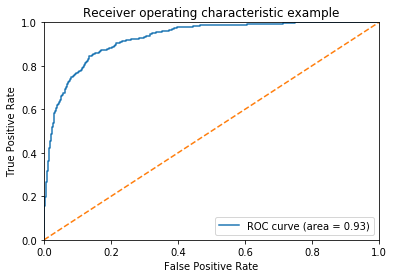

In [208]:
fpr, tpr, _ = roc_curve(y_test == 1, pred_rew_prob)
roc_auc = roc_auc_score(y_test, pred_rew_prob)
print ("AUC: ", roc_auc)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [209]:
print("Recall Score:")
print(recall_score(y_test,y_pred_tree))
print("Precision Score:")
print(precision_score(y_test,y_pred_tree))
print("Confusion matrix")
confusion_matrix(y_test,y_pred_tree)

Recall Score:
0.8551532033426184
Precision Score:
0.3318918918918919
Confusion matrix


array([[3523,  618],
       [  52,  307]])

In [210]:
from sklearn.metrics import auc, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test,pred_prob)
auc(recall, precision)

0.6143590402058656

In [211]:
print("Recall Score:")
print(recall_score(y_test,pred_rew))
print("Precision Score:")
print(precision_score(y_test,pred_rew))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew)

Recall Score:
0.298050139275766
Precision Score:
0.7430555555555556
Confusion matrix


array([[4104,   37],
       [ 252,  107]])

In [212]:
from sklearn.metrics import auc, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test,pred_rew)
auc(recall, precision)

0.5485528474156608

In [213]:
thresh = np.arange(0,1,.05)
scores = []

for t in thresh:
    preds = [1 if i>t else 0 for i in pred_rew_prob]
    scores.append(f1_score(y_test, preds))

/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.30000000000000004


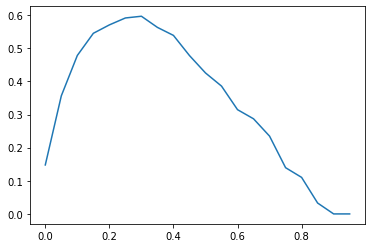

In [214]:
print(thresh[np.argmax(scores)])
plt.plot(thresh,scores)

In [215]:
pred_rew_best = [1 if i>thresh[np.argmax(scores)] else 0 for i in pred_rew_prob]
print("Recall Score:")
print(recall_score(y_test,pred_rew_best))
print("Precision Score:")
print(precision_score(y_test,pred_rew_best))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew_best)

Recall Score:
0.5766016713091922
Precision Score:
0.6179104477611941
Confusion matrix


array([[4013,  128],
       [ 152,  207]])

## XGBOOST

In [216]:
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          table=True,
                          display_all_params=True):

    '''Display grid search results
    modified from https://www.kaggle.com/grfiv4/displaying-the-results-of-a-grid-search
    Arguments
    ---------

    grid_clf           the estimator resulting from a grid search
                       for example: grid_clf = GridSearchCV( ...

    param_name         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    table              boolean: should a table be produced?
                       Default: True

    display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearch_table_plot(grid_clf, "min_samples_leaf")

                          '''
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_


    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')
    scores_df = scores_df[scores_df.columns.drop(list(scores_df.filter(regex='time')))] #drop time parameters

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    if table:
        display(scores_df \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

In [217]:
# feature importance
xgb_model = xgb.XGBClassifier(objective='binary:logistic',
              learning_rate= 0.05, #so called `eta` value
              max_depth= 6,
              min_child_weight= 11,
              silent= 1,
              subsample= 0.8,
              colsample_bytree= 0.7,
              n_estimators= 50, #number of trees 
              missing=-999, #replacing missing values
              reg_lambda=1.5,
              seed= 1337)

xgb_model.fit(X_train,y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)
scores = cross_val_score(xgb_model, X_train, y_train, cv=5)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)

In [218]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

importances = xgb_model.feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=feature_names)
important_features.sort_values(ascending=False)

Accuracy: 0.86 (+/- 0.04)


DEATHRATE_CAT__1.0        1.000000
mechvent                  0.802753
DEATHRATE_CAT__2.0        0.769179
SpO2_Min                  0.628264
electivesurgery           0.585864
cardiovascular            0.558191
urineoutput               0.342304
gcs                       0.338639
renal                     0.297923
SysBP_Min                 0.255134
RespRate_Mean             0.248274
preiculos                 0.197770
respiration               0.192990
meanbp                    0.191308
liver                     0.186846
DiasBP_Min                0.176107
age                       0.169171
heartrate                 0.150438
MeanBP_Min                0.148566
Glucose_Mean              0.146076
RespRate_Min              0.145241
HeartRate_Max             0.122729
Glucose_Min               0.117511
TempC_Min                 0.107029
MeanBP_Mean               0.100357
SysBP_Mean                0.099141
Glucose_Max               0.098649
cns                       0.096792
HeartRate_Mean      

In [219]:
q1 = 0.1 # population
r1 = 0.5 # training set

# Reweight class prediction probability

pred_rew_prob = reweight(y_pred_prob_xgb[:,1], q1, r1) #[i for i in 
# y_pred_prob = np.append(y_pred_prob, np.atleast_2d(pred_rew_prob).T, axis=1)
# Classification
pred_rew = [1 if i>0.5 else 0 for i in pred_rew_prob]

pred_prob = y_pred_prob_xgb[:,1]

AUC:  0.9216941260672707


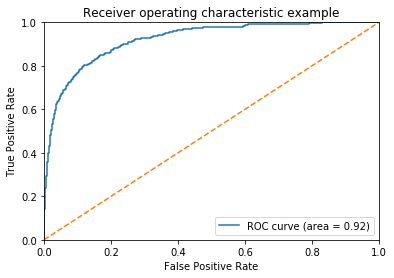

In [220]:
fpr, tpr, _ = roc_curve(y_test == 1, pred_rew_prob)
roc_auc = roc_auc_score(y_test, pred_rew_prob)
print ("AUC: ", roc_auc)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [221]:
print("Recall Score:")
print(recall_score(y_test,y_pred_xgb))
print("Precision Score:")
print(precision_score(y_test,y_pred_xgb))
print("Confusion matrix")
confusion_matrix(y_test,y_pred_xgb)

Recall Score:
0.83008356545961
Precision Score:
0.31769722814498935
Confusion matrix


array([[3501,  640],
       [  61,  298]])

In [222]:
from sklearn.metrics import auc, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test,pred_prob)
auc(recall, precision)

0.6231994978665307

In [223]:
print("Recall Score:")
print(recall_score(y_test,pred_rew))
print("Precision Score:")
print(precision_score(y_test,pred_rew))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew)

Recall Score:
0.14763231197771587
Precision Score:
0.8983050847457628
Confusion matrix


array([[4135,    6],
       [ 306,   53]])

In [224]:
from sklearn.metrics import auc, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test,pred_rew)
auc(recall, precision)

0.5569686983617392

In [225]:
thresh = np.arange(0,1,.05)
scores = []

for t in thresh:
    preds = [1 if i>t else 0 for i in pred_rew_prob]
    scores.append(f1_score(y_test, preds))

/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.25


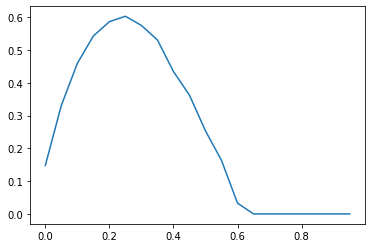

In [226]:
print(thresh[np.argmax(scores)])
plt.plot(thresh,scores)

In [227]:
pred_rew_best = [1 if i>thresh[np.argmax(scores)] else 0 for i in pred_rew_prob]
print("Recall Score:")
print(recall_score(y_test,pred_rew_best))
print("Precision Score:")
print(precision_score(y_test,pred_rew_best))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew_best)

Recall Score:
0.5933147632311978
Precision Score:
0.6138328530259366
Confusion matrix


array([[4007,  134],
       [ 146,  213]])

## Logistic Regression

In [228]:
from sklearn.linear_model import LogisticRegression

lregr = LogisticRegression(penalty='l2', C=100.0, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=500)

# Fiting logistic regression

lregr.fit(X_train,y_train)      

#Predictions
y_pred_log = lregr.predict(X_test)
y_pred_prob_log = lregr.predict_proba(X_test)

In [229]:
q1 = 0.1 # population
r1 = 0.5 # training set

# Reweight class prediction probability

pred_rew_prob = reweight(y_pred_prob_log[:,1], q1, r1) #[i for i in 

# Classification
pred_rew = [1 if i>0.5 else 0 for i in pred_rew_prob]

pred_prob = y_pred_prob_log[:,1]

AUC:  0.903032316955454


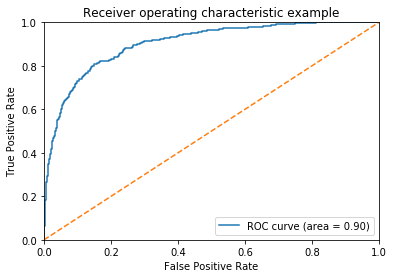

In [230]:
fpr, tpr, _ = roc_curve(y_test == 1, pred_rew_prob)
roc_auc = roc_auc_score(y_test, pred_rew_prob)
print ("AUC: ", roc_auc)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [231]:
print("Recall Score:")
print(recall_score(y_test,y_pred_log))
print("Precision Score:")
print(precision_score(y_test,y_pred_log))
print("Confusion matrix")
confusion_matrix(y_test,y_pred_xgb)

Recall Score:
0.807799442896936
Precision Score:
0.3078556263269639
Confusion matrix


array([[3501,  640],
       [  61,  298]])

In [232]:
from sklearn.metrics import auc, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test,pred_prob)
auc(recall, precision)

0.5493326716532779

In [233]:
print("Recall Score:")
print(recall_score(y_test,pred_rew))
print("Precision Score:")
print(precision_score(y_test,pred_rew))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew)

Recall Score:
0.4456824512534819
Precision Score:
0.6060606060606061
Confusion matrix


array([[4037,  104],
       [ 199,  160]])

In [234]:
from sklearn.metrics import auc, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test,pred_rew)
auc(recall, precision)

0.5479826397681551

In [235]:
thresh = np.arange(0,1,.05)
scores = []

for t in thresh:
    preds = [1 if i>t else 0 for i in pred_rew_prob]
    scores.append(f1_score(y_test, preds))

0.35000000000000003


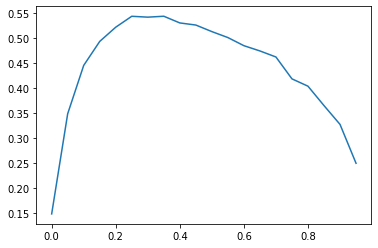

In [236]:
print(thresh[np.argmax(scores)])
plt.plot(thresh,scores)

In [237]:
pred_rew_best = [1 if i>thresh[np.argmax(scores)] else 0 for i in pred_rew_prob]
print("Recall Score:")
print(recall_score(y_test,pred_rew_best))
print("Precision Score:")
print(precision_score(y_test,pred_rew_best))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew_best)

Recall Score:
0.5543175487465181
Precision Score:
0.5349462365591398
Confusion matrix


array([[3968,  173],
       [ 160,  199]])

## Ensemble

In [238]:
def get_models():
    #Generate a library of simple learners
    rf = RandomForestClassifier(n_estimators=20)
    tree = GradientBoostingClassifier(n_estimators=50)
    xgb_mod = xgb.XGBClassifier(objective='binary:logistic',
              learning_rate= 0.05, #so called `eta` value
              max_depth= 6,
              min_child_weight= 11,
              silent= 1,
              subsample= 0.8,
              colsample_bytree= 0.7,
              n_estimators= 50, #number of trees 
              missing=-999, #replacing missing values
              reg_lambda=1.5,
              seed= 1337)
    lr = LogisticRegression(penalty='l2', C=100.0, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=500)

    models = {'random forest': rf,
              'gradient boosting': tree,
              'xgboost': xgb_mod,
              'logistic': lr,
              }

    return models

models = get_models()

In [239]:
meta_learner = ExtraTreesClassifier(
    n_estimators=50,
    bootstrap=True,
    max_features=0.7)

In [240]:
# Instantiate the ensemble with 5 folds (stacking meta-learner)
sl = SuperLearner(
    folds=5,
    verbose=2
)

# Add the base learners and the meta learner
sl.add(list(models.values()), proba=True)
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(X_train, y_train)

y_pred_prob_sl = sl.predict_proba(X_test)


Fitting 2 layers
Processing layer-1             done | 00:00:02
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:03

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00


In [241]:
y_pred_sl = [1 if i>0.5 else 0 for i in y_pred_prob_sl[:,1]]

In [242]:
q1 = 0.1 # population
r1 = 0.5 # training set

# Reweight class prediction probability


pred_rew_prob = reweight(y_pred_prob_sl[:,1], q1, r1) #[i for i in 

# Classification
pred_rew = [1 if i>0.5 else 0 for i in pred_rew_prob]

pred_prob = y_pred_prob_sl[:,1]

AUC:  0.8890371372893794


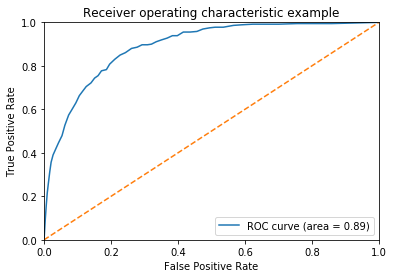

In [243]:
fpr, tpr, _ = roc_curve(y_test == 1, pred_rew_prob)
roc_auc = roc_auc_score(y_test, pred_rew_prob)
print ("AUC: ", roc_auc)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [244]:
print("Recall Score:")
print(recall_score(y_test,y_pred_sl))
print("Precision Score:")
print(precision_score(y_test,y_pred_sl))
print("Confusion matrix")
confusion_matrix(y_test,y_pred_sl)

Recall Score:
0.8495821727019499
Precision Score:
0.24497991967871485
Confusion matrix


array([[3201,  940],
       [  54,  305]])

In [245]:
from sklearn.metrics import auc, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test,pred_prob)
auc(recall, precision)

0.46912316637093116

In [246]:
print("Recall Score:")
print(recall_score(y_test,pred_rew))
print("Precision Score:")
print(precision_score(y_test,pred_rew))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew)

Recall Score:
0.31197771587743733
Precision Score:
0.6153846153846154
Confusion matrix


array([[4071,   70],
       [ 247,  112]])

In [247]:
from sklearn.metrics import auc, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test,pred_rew)
auc(recall, precision)

0.49112561007547084

In [248]:
thresh = np.arange(0,1,.05)
scores = []

for t in thresh:
    preds = [1 if i>t else 0 for i in pred_rew_prob]
    scores.append(f1_score(y_test, preds))

0.30000000000000004


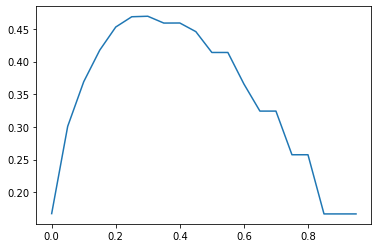

In [249]:
print(thresh[np.argmax(scores)])
plt.plot(thresh,scores)

In [250]:
pred_rew_best = [1 if i>thresh[np.argmax(scores)] else 0 for i in pred_rew_prob]
print("Recall Score:")
print(recall_score(y_test,pred_rew_best))
print("Precision Score:")
print(precision_score(y_test,pred_rew_best))
print("Confusion matrix")
confusion_matrix(y_test,pred_rew_best)

Recall Score:
0.5264623955431755
Precision Score:
0.42376681614349776
Confusion matrix


array([[3884,  257],
       [ 170,  189]])

## Feed-Forward Neural Net

In [254]:
# To be added from FFNN_Mortality_Predictions file once issue with:
# type object 'h5py.h5f.FileID' has no attribute '__reduce_cython__' 
# is fixed

In [ ]:
#These lines might be required for the code to run below:
#conda install keras
#conda install h5py=2.8.0

In [255]:
from copy import deepcopy
import sys

from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers import BatchNormalization
from keras.layers.merge import concatenate
from keras.layers.recurrent import LSTM, GRU 
from keras.models import model_from_json, Sequential
from keras.optimizers import RMSprop
from keras import optimizers
import numpy as np
from sklearn.model_selection import StratifiedKFold
#import theano


sys.path.append("..\..")
from keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger

from random import choice
from string import ascii_uppercase

import os
from random import choice

Using TensorFlow backend.


In [256]:
import os
import warnings
import sys
from keras.callbacks import Callback
import numpy as np


class EarlyStoppingRestoringWeights(Callback):
    def __init__(self, monitor='val_loss', patience=0, verbose=0, 
                 weight_path = None):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.verbose = verbose
        self.weight_path = weight_path
        self.best = np.Inf
        self.wait = 0

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" \
                % (self.monitor), RuntimeWarning)
        sys.stdout.flush()
        if current < self.best:
            self.best = current
            self.model.save_weights(self.weight_path, overwrite=True)
            self.wait = 0
        else:
            if self.wait >= self.patience:
                if self.verbose > 0:
                    print("Epoch %05d: early stopping" % (epoch))
                self.model.stop_training = True
            self.wait += 1

    def on_train_end(self, epoch, logs={}):
        try:
            self.model.load_weights(self.weight_path)
            os.remove(self.weight_path)
        except Exception as exc:
            print ('error while loading and removing weights', str(exc))

In [307]:
class FeedForwardNetwork(object):
    def __init__(self, hidden_dim=20, final_activation='sigmoid', loss='binary_crossentropy',
                 batch_size=10, nb_epoch=50, learning_rate=0.001, validation_split=0.25, patience=20, early_stopping='True_BestWeight', ffn_depth=2,
                 batch_normalization='False'):
        self.hidden_dim = hidden_dim
        self.final_activation = final_activation
        self.loss = loss
        self.batch_size = batch_size
        self.nb_epoch = nb_epoch
        self.learning_rate = learning_rate
        self.validation_split = validation_split
        self.patience = patience
        self.EarlyStopping = early_stopping
        self.type_MMDL = 1
        #self.random_str = ''.join(choice(ascii_uppercase) for i in range(12))
        self.ffn_depth = ffn_depth
        self.batch_normalization = batch_normalization

    # get the i-th (hidden) layer output as the features of input X
    def transform_features(self, X, layers=None):
        pass
 
    def transform(self, X):
        return None

    # sklearn.$anymodel$.fit
    def fit(self, X, y):
        n_features = X.shape[1]
        model = Sequential()

        hidden_dim = self.hidden_dim
        final_activation = self.final_activation
        loss = self.loss
        if hidden_dim is None:
            hidden_dim = 8 * n_features

        model.add(Dense(hidden_dim, input_shape=(n_features, ), activation='sigmoid'))
        model.add(Dropout(0.1))
        for t in range(self.ffn_depth - 1):
            print('layer%d'%t)
            model.add(Dense(hidden_dim, activation='sigmoid'))
            model.add(Dropout(0.2))
        model.add(Dense(1, activation=None))
        if self.batch_normalization == 'True':
            model.add(BatchNormalization())
        model.add(Activation(activation=final_activation))
        self.model = model
        print ('number of parameters: ' + str(self.model.count_params()))
        print ('before compiling')
        self.model.compile(loss=loss, optimizer=RMSprop(lr=self.learning_rate), metrics=['accuracy'])
        print ('before fitting')

        if self.EarlyStopping == 'True_BestWeight':
            self.model.fit(
                x=X, y=y,
                batch_size=self.batch_size, nb_epoch=self.nb_epoch,
                # show_accuracy=True,
                verbose=2, shuffle=False,
                validation_split=self.validation_split,
                #callbacks = [EarlyStopping(patience=10)],
                #callbacks=[EarlyStoppingRestoringWeights(patience=self.patience, weight_path='ES_best_' + str(
                #    self.type_MMDL) + '_' + self.random_str + ' .h5')],
            )

        elif self.EarlyStopping == 'True':
            self.model.fit(
                x=X, y=y,
                batch_size=self.batch_size, nb_epoch=self.nb_epoch,
                # show_accuracy=True,
                verbose=2,
                validation_split=self.validation_split,
                callbacks=[EarlyStopping(patience=self.patience)],
            )

        elif self.EarlyStopping == 'False':
            self.model.fit(
                x=X, y=y,
                batch_size=self.batch_size, nb_epoch=self.nb_epoch,
                # show_accuracy=True,
                verbose=2,
                validation_split=self.validation_split,
            )

        print ('after fitting')
        return self
            
    # get output layer values of input X
    def decision_function(self, X):
        return self.model.predict(X)
        
    # get prediction of input X (compare output value and threshold)
    def predict(self, X):
        if self.loss == 'mean_squared_error':
            return self.model.predict(X)
        else:
            return self.model.predict_classes(X)

### Balanced

In [322]:
model = FeedForwardNetwork()
model.fit(X_train,y_train)

layer0
number of parameters: 1461
before compiling
before fitting


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1530 samples, validate on 510 samples
Epoch 1/50
 - 3s - loss: 0.7425 - accuracy: 0.4928 - val_loss: 0.6525 - val_accuracy: 0.6333
Epoch 2/50
 - 1s - loss: 0.6600 - accuracy: 0.6569 - val_loss: 0.9374 - val_accuracy: 0.1824
Epoch 3/50
 - 1s - loss: 0.6533 - accuracy: 0.6745 - val_loss: 1.1565 - val_accuracy: 0.0667
Epoch 4/50
 - 1s - loss: 0.6634 - accuracy: 0.6739 - val_loss: 1.3089 - val_accuracy: 0.0255
Epoch 5/50
 - 1s - loss: 0.6669 - accuracy: 0.6771 - val_loss: 1.4037 - val_accuracy: 0.0000e+00
Epoch 6/50
 - 1s - loss: 0.6850 - accuracy: 0.6765 - val_loss: 1.4522 - val_accuracy: 0.0137
Epoch 7/50
 - 1s - loss: 0.6690 - accuracy: 0.6856 - val_loss: 1.4690 - val_accuracy: 0.0843
Epoch 8/50
 - 1s - loss: 0.6732 - accuracy: 0.6889 - val_loss: 1.4885 - val_accuracy: 0.1353
Epoch 9/50
 - 1s - loss: 0.6572 - accuracy: 0.6908 - val_loss: 1.4699 - val_accuracy: 0.2255
Epoch 10/50
 - 1s - loss: 0.6586 - accuracy: 0.7020 - val_loss: 1.4514 - val_accuracy: 0.2804
Epoch 11/50
 - 1s 

In [324]:
#Balanced Input
y_pred_NN3 = model.predict(X_test)

print("Recall Score:")
print(recall_score(y_test,y_pred_NN3))
print("Precision Score:")
print(precision_score(y_test,y_pred_NN3))
print("Confusion matrix")
confusion_matrix(y_test,y_pred_NN3)

Recall Score:
0.6601671309192201
Precision Score:
0.45489443378119004
Confusion matrix


array([[3857,  284],
       [ 122,  237]])

In [325]:
from sklearn.metrics import auc, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test,y_pred_NN3)
auc(recall, precision)

0.5710863379057606

### Unbalanced

In [328]:
model = FeedForwardNetwork()
model.fit(X_train_unbalanced,y_train_unbalanced)

layer0
number of parameters: 1461
before compiling
before fitting


/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1530 samples, validate on 510 samples
Epoch 1/50
 - 2s - loss: 0.7484 - accuracy: 0.5261 - val_loss: 0.7204 - val_accuracy: 0.3941
Epoch 2/50
 - 1s - loss: 0.6905 - accuracy: 0.6484 - val_loss: 1.0328 - val_accuracy: 0.0667
Epoch 3/50
 - 1s - loss: 0.6914 - accuracy: 0.6693 - val_loss: 1.2571 - val_accuracy: 0.0000e+00
Epoch 4/50
 - 1s - loss: 0.7055 - accuracy: 0.6719 - val_loss: 1.3973 - val_accuracy: 0.0000e+00
Epoch 5/50
 - 1s - loss: 0.7078 - accuracy: 0.6732 - val_loss: 1.4700 - val_accuracy: 0.0000e+00
Epoch 6/50
 - 1s - loss: 0.7164 - accuracy: 0.6752 - val_loss: 1.5033 - val_accuracy: 0.0000e+00
Epoch 7/50
 - 1s - loss: 0.7110 - accuracy: 0.6824 - val_loss: 1.5200 - val_accuracy: 0.0000e+00
Epoch 8/50
 - 1s - loss: 0.6961 - accuracy: 0.6837 - val_loss: 1.4904 - val_accuracy: 0.1176
Epoch 9/50
 - 1s - loss: 0.6914 - accuracy: 0.6915 - val_loss: 1.4727 - val_accuracy: 0.2020
Epoch 10/50
 - 1s - loss: 0.6658 - accuracy: 0.7007 - val_loss: 1.4361 - val_accuracy: 0.2627
Ep

In [329]:
y_pred_NN3 = model.predict(X_test)

print("Recall Score:")
print(recall_score(y_test_unbalanced,y_pred_NN3))
print("Precision Score:")
print(precision_score(y_test_unbalanced,y_pred_NN3))
print("Confusion matrix")
confusion_matrix(y_test_unbalanced,y_pred_NN3)

Recall Score:
0.6545961002785515
Precision Score:
0.4571984435797665
Confusion matrix


array([[3862,  279],
       [ 124,  235]])

In [330]:
from sklearn.metrics import auc, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test_unbalanced,y_pred_NN3)
auc(recall, precision)

0.5696750497069368

In [162]:
from sklearn.model_selection import GridSearchCV

MyXGB = xgb.XGBClassifier() #objective='reg:squarederror'
parameters = {'nthread':[3], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [90]}

grid_knn_acc = GridSearchCV(MyXGB, param_grid = parameters, scoring = 'r2', cv=5, refit=True,n_jobs=3)
grid_knn_acc.fit(X, y)

/Users/keyvanamini/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_l...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=3,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [5, 6, 7], 'min_child_w

In [169]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=140, 
                                                  max_depth=5,min_child_weight=1, gamma=0, subsample=0.8, 
                                                  colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, 
                                                  scale_pos_weight=1,seed=27), param_grid = param_test1, 
                                                  scoring='roc_auc',n_jobs=2,cv=5)
gsearch1.fit(X_train,y_train)
#gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='warn', n_jobs=2,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             pre_dispatch='2*n_jobs', refit=True, retu

In [112]:
main_df2 = pd.read_csv('main_df2.csv')